In [1]:
import logging
import os
import time
import warnings
from functools import partial  # for pd.Series.map(ztfs)
from multiprocessing.pool import Pool
from pathlib import Path

import cartopy.crs as ccrs
import geopandas
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib.colors import BoundaryNorm
from tqdm import tqdm

import G211
import lightning
from ml_functions import brier_skill_score, get_args, get_flash_pred
from spc import get_issuance_time
from statisticplot import ax_features, stat_plots

sns.set_theme()

logging.basicConfig(level=logging.WARNING, format="%(asctime)s %(message)s", force=True)
tmpdir = Path(os.getenv("TMPDIR"))

2024-06-11 08:16:30.592326: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 08:16:32.269103: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#%load_ext autoreload
#%autoreload 2

In [3]:
# map projection
map_crs = G211.g211
grid = G211.grid
grid = grid.to_crs(ccrs.PlateCarree())
dpi = 200
conus_mask = G211.mask

### Load SPC Tstm Outlook
downloaded by [get_enhtstm.ipynb](get_enhtstm.ipynb)


In [4]:
tmpdir = Path(os.getenv("TMPDIR"))
sfiles = (tmpdir / "enhtstm").glob("????/*.zip")
sfiles = sorted(sfiles)
column = "DN"
sfiles[0].name, sfiles[-1].name, len(sfiles)

('enh00_20200101_012000_202001010525-shp.zip',
 'enh20_20230630_301600_202306301252-shp.zip',
 15425)

In [5]:
obsvar = "cg"
o_thresh = 1
twin = 4
rptdist = 20
clobber = False

platform = "glm" if obsvar == "flashes" else "wbug"

f = f"{obsvar}_{rptdist}km_{twin}hr"
# Define observation/probability thresholds
thresh = pd.Series([o_thresh], name=f"{obsvar} threshold")
pthreshSPC = pd.Series([0, 10, 40, 70], name="fcst prob\nthresh") / 100.0
args = get_args(o_thresh, twin)
args

Namespace(batchnorm=True, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=30, labels=['cg_20km_4hr', 'ic_20km_4hr', 'cg.ic_20km_4hr', 'flashes_20km_4hr', 'cg_40km_4hr', 'ic_40km_4hr', 'cg.ic_40km_4hr', 'flashes_40km_4hr'], fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=1, folds=None, kfold=1, idate=None, ifile=None, learning_rate=0.001, model='HRRR', neurons=[1024], nfits=10, nprocs=0, optimizer='Adam', reg_penalty=0.0, savedmodel='/glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr', seed=-1, trainstart=Timestamp('2019-10-02 00:00:00'), trainend=Timestamp('2020-12-02 00:00:00'), teststart=Timestamp('2021-01-01 00:00:00'), testend=Timestamp('2022-01-01 00:00:00'), twin=4, suite='default')

In [6]:
def spc_forecast_obs(sfile: str) -> pd.DataFrame:
    """
    Parameters
    ----------
    sfile:str
        a path like
        '/glade/derecho/scratch/ahijevyc/tmp/enhtstm/2020/enh00_20200105_052000_202001051206-shp.zip'
        from which you can derive issuance and valid time range

    Returns
    -------
        pd.DataFrame with forecast and observations from same period
    """

    assert twin > 1, (
        "no NNPF time windows for twin == 1 that conform to SPC time windows. "
        "NNPF twin=1 start and end on the half-hour, while SPC time windows "
        "start and end on the hour. But that is okay. You can still plot "
        "NNPF performance at all valid times, regardless of SPC fcst below."
    )

    f = geopandas.read_file(sfile).to_crs(ccrs.PlateCarree())
    record = os.path.basename(sfile)

    # Get forecast valid start and end from sfile string.
    issue, valid_start, valid_end = get_issuance_time(record)
    logging.info(f"{issue} {valid_start} {valid_end}")

    # Get observations from DataFrame from ml_functions.load_df()
    # instead of lightning.get_obs()
    # so you have the same data, and don't "repeat" the same
    # function with different code.
    # get_obs allows GLM or ENTLN to be missing for a time
    # but load_df does not.

    # Uses `obs` DataFrame already sliced from Y DataFrame outside function.
    # I don't include it as an input parameter because this is run in a Pool.
    # I think it would make a copy of obs for each worker
    # if I included it as an input parameter.

    valid_times = pd.date_range(
        start=valid_start + pd.Timedelta(hours=twin / 2),
        end=valid_end - pd.Timedelta(hours=twin / 2),
        freq=f"{twin}H",
    )
    # if all expected valid_times are available
    if all(
        [valid_time in obs.index.get_level_values("valid_time") for valid_time in valid_times]
    ):
        with warnings.catch_warnings():
            warnings.simplefilter(action="ignore", category=FutureWarning)
            # Reduce initialization_time dimension for multiple
            # initialization_times that have the same valid_time.
            # The validation data, obs, are the same for each init time so just
            # take the first.
            o = (
                obs.loc[
                    (slice(None), slice(None), slice(None), valid_times),
                    args.labels,
                ]
                .groupby(["x", "y", "valid_time"])
                .first()
            )
        o = o.groupby(
            ["x", "y"]
        ).sum()  # sum flashes for each (x,y) along valid_times dimension
    else:
        return None

    # Assign value to conus grid points within polygons
    f = grid[conus_mask.values.ravel()].sjoin(f, how="left")

    f["record"] = record
    f["issue"] = issue
    # convert to str avoids TypeError: Object of type Timestamp is not JSON serializable
    # when saving to parquet
    f["valid_start"] = valid_start.strftime("%Y%m%d %H:%M")
    f["valid_end"] = valid_end.strftime("%Y%m%d %H:%M")
    columns = ["record", "DN", "issue", "valid_start", "valid_end"]
    # fill missing fcst prob (outside any polygon) with 0. Join with obs.
    f = f[columns].fillna(0).join(o)
    f = f.set_index("record", append=True)

    return f

### Load DataFrame of NNPF forecasts / observations

In [7]:
# get observations from NNPF forecast/obs DataFrame
Y = get_flash_pred(args, clobber=clobber)

# ensmean of fits and folds
# Don't be clever by subtracting {"fit", "fold"} set from Y.index.names
# Order of returned list of levels was random. valid_time did not always come 2nd.
levels = ["initialization_time", "valid_time", "y", "x", "forecast_hour", "lat", "lon"]
logging.warning(f"groupby {levels} for ensmean")
ensmean = Y.groupby(level=levels).mean()

# obs used in spc_forecast_obs() defined above
logging.warning("obs (label) slice")
obs = ensmean.xs("y_label", axis="columns", level=0)

2024-06-11 08:23:11,707 read saved model output /glade/derecho/scratch/ahijevyc/tmp/Y.001+4hr.2021-01-01 00:00:00-2022-01-01 00:00:00.par
2024-06-11 08:24:09,639 done
2024-06-11 08:24:09,642 groupby ['initialization_time', 'valid_time', 'y', 'x', 'forecast_hour', 'lat', 'lon'] for ensmean
2024-06-11 08:25:19,667 obs (label) slice


## Verify SPC Thunderstorm Outlook

### Match obs to each SPC forecast in parallel

In [8]:
ffile = tmpdir / f"spc_fcst.{twin}hr.par"

if not clobber and os.path.exists(ffile):  # and os.path.exists(ofile):
    logging.warning(f"read {ffile} {os.path.getsize(ffile)/1e6:.1f}M ")
    spc_fcst = pd.read_parquet(ffile)
else:
    logging.warning(f"make new file {ffile}")
    if twin == 2:
        logging.warning("Sure u want to compare NNPFs with 2-hour time window to SPC?")

    assert obs[f].sum() > 0, (
        "no lightning obs. did you run cells further down that changed"
        " obs and then come back"
        " to this cell?"
    )

    # Use multiple cpus (like 16) and 60+GB memory.
    # 16 cpu, 89 GB, 16 processes took 17 minutes (twin=4)
    with Pool(processes=18) as pool:
        result = pool.map(
            spc_forecast_obs,
            tqdm(sfiles),
        )

    spc_fcst = pd.concat([x for x in result if x is not None])
    spc_fcst.to_parquet(ffile)

# tried saving this to parquet ofile but tuple in column broke arrow engine
spc_fcst["prodid"] = list(
    zip(
        spc_fcst.issue,
        pd.to_datetime(spc_fcst.valid_start).dt.hour,
        pd.to_datetime(spc_fcst.valid_end).dt.hour,
    )
)

logging.info("trim spc_fcst to testing range of neural network")
before_trim = len(spc_fcst)
spc_fcst = spc_fcst[
    (pd.to_datetime(spc_fcst.valid_start) >= pd.to_datetime(args.teststart))
    & (pd.to_datetime(spc_fcst.valid_end) <= pd.to_datetime(args.testend))
]
logging.warning(
    f"kept {len(spc_fcst)}/{before_trim} ({len(spc_fcst)/before_trim:%}) spc fcsts"
)

assert "enh00_20211231_312000_202112310559-shp.zip" in spc_fcst.index.get_level_values(
    "record"
)

2024-06-11 08:25:20,062 read /glade/derecho/scratch/ahijevyc/tmp/spc_fcst.4hr.par 4.1M 
2024-06-11 08:25:26,769 kept 5579928/6058656 (92.098446%) spc fcsts


[('0600', 12, 16)] [353] 0.082
[('0600', 16, 20)] [330] 0.118
[('1300', 16, 20)] [378] 0.142
[('0600', 20, 0)] [335] 0.276
[('1300', 20, 0)] [371] 0.287
[('1700', 20, 0)] [362] 0.309
[('1300', 0, 4)] [351] 0.178
[('1700', 0, 4)] [357] 0.211
[('2100', 0, 4)] [367] 0.243
[('1700', 4, 12)] [344] 0.161
[('2100', 4, 12)] [366] 0.194
[('0130', 4, 12)] [352] 0.266


2024-06-11 08:25:43,534 /glade/derecho/scratch/ahijevyc/tmp/enhtstm.001+cg_20km_4hr_20km.png


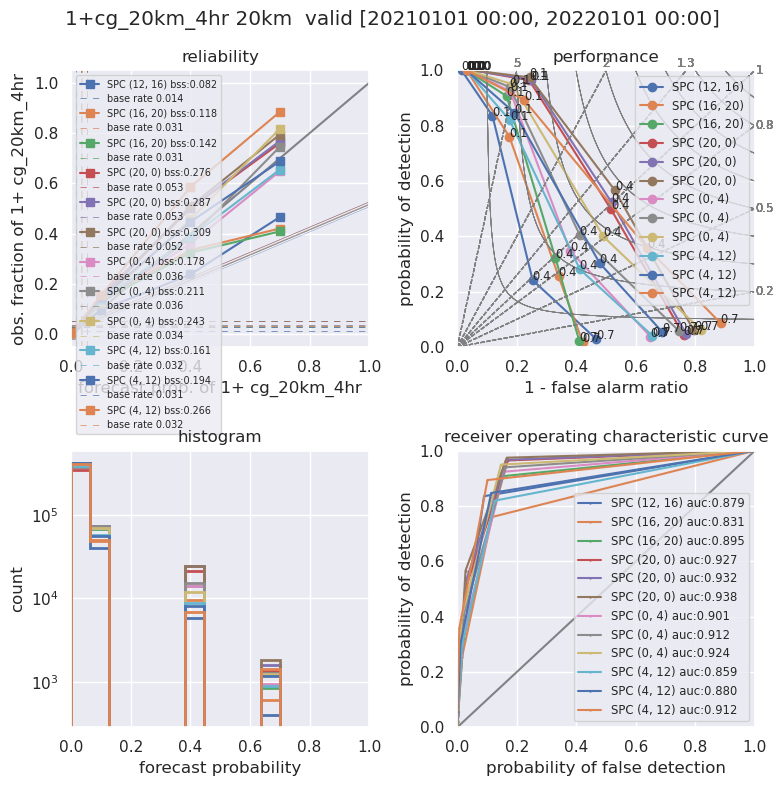

In [9]:
def valid_hour_str(prodids):
    valid_hour_range = prodids[0][1:]  # last 2 elements of first prodids tuple
    same_valid_hour_range = len(set([x[1:] for x in prodids])) == 1
    if same_valid_hour_range:
        return " " + str(valid_hour_range)
    return ""


# Aggregate by valid time
prodidss = [
    [("0600", 12, 16)],
    [("0600", 16, 20), ("1300", 16, 20)],
    [("0600", 20, 0), ("1300", 20, 0), ("1700", 20, 0)],
    [("1300", 0, 4), ("1700", 0, 4), ("2100", 0, 4)],
    [("1700", 4, 12), ("2100", 4, 12), ("0130", 4, 12)],
]

# Flatten list of lists to get every issuance and valid time in its own list
prodidss = [[x] for prodid in prodidss for x in prodid]
# All together
#prodidss = [[x for prodid in prodidss for x in prodid]]

ncols, nrows = 2, 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 4, nrows * 4))
title = ""


spc_bss = {}
for prodids in prodidss:
    logging.info(f"forecast products for {len(prodids)} prodids")
    ihr = spc_fcst.prodid.isin(prodids)
    assert ihr.sum()
    #print(ihr.sum() / G211.mask.values.sum())

    # 1308 CONUS points per forecast
    cnt = (spc_fcst[ihr].groupby("prodid").size() /G211.mask.values.sum()).astype(int)

    print(cnt.index.values, cnt.values, end=" ")

    title += "  ".join([f"{c}{v}" for c, v in list(zip(cnt, cnt.index))])

    thisf = spc_fcst.loc[ihr, "DN"] / 100
    thisf.name = "SPC" + valid_hour_str(prodids)

    fig = stat_plots(
        spc_fcst.loc[ihr, f],
        thisf,
        thresh=thresh,
        pthresh=pthreshSPC,
        o_thresh_roc=o_thresh,
        sep=0.01,
        n_bins=11,
        fig=fig,
    )
    if len(prodids) == 1:
        # Remember this for later
        spc_bss[prodids[0]] = brier_skill_score(spc_fcst.loc[ihr,f]>=o_thresh, thisf)

title = f"{o_thresh}+{f} {rptdist}km"
title += f"  valid [{spc_fcst.valid_start.min()}, {spc_fcst.valid_end.max()}]"
plt.suptitle(title, wrap=True)
plt.tight_layout()
ofile = tmpdir / f"enhtstm.{o_thresh:03d}+{f}_{rptdist}km.png"
plt.savefig(ofile, dpi=dpi)
logging.warning(ofile)

2024-06-11 08:25:44,538 /glade/derecho/scratch/ahijevyc/tmp/cnt.png


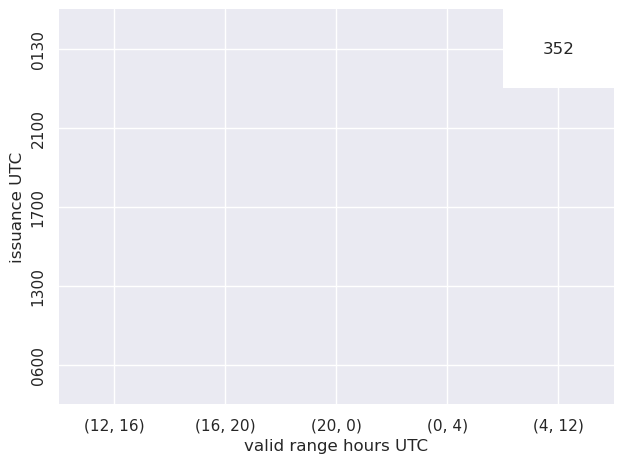

In [10]:
plt.close('all')
def plot_cnt(cnt, **kwargs):
    df = pd.DataFrame(
        cnt.index.tolist(),
        columns=["issuance UTC", "valid_start_hour", "valid_end_hour"],
    )
    df["valid range hours UTC"] = list(zip(df.valid_start_hour, df.valid_end_hour))
    df["n"] = cnt.values
    df = df.reset_index().pivot(
        columns="valid range hours UTC", index="issuance UTC", values="n"
    )
    df = df.reindex(
        ["0130", "2100", "1700", "1300", "0600"],
        columns=[(12, 16), (16, 20), (20, 0), (0, 4), (4, 12)],
    )
    g = sns.heatmap(df, annot=True, fmt="3.0f", cbar=False, **kwargs)
    return g


g = plot_cnt(
    cnt,
    cmap=mpl.colors.LinearSegmentedColormap.from_list(
        "cnt", ["white", fig.get_axes()[0].get_lines()[-1].get_color()]
    ),
)
ofile = tmpdir / "cnt.png"
plt.tight_layout()
plt.savefig(ofile, dpi=dpi)
logging.warning(ofile)

## Verify neural network probability forecast NNPF

In [11]:
ensmean.index.get_level_values("forecast_hour").unique()

Index([48, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
      dtype='int32', name='forecast_hour')

## Get obsvar at rptdist and twin from NNPF obs and fcst
### Plot NNPF performance at all valid times, regardless of SPC fcst

In [12]:
from shapely.geometry import Polygon

def statjob(group: pd.DataFrame) -> pd.DataFrame:
    logging.info(f"statjob: {group.name}")
    # seperate y_pred and labels and drop level 0
    y_pred = group.xs("y_pred", axis="columns", level=0)
    # labels went from bool to object dtype, so fix it or roc_auc_score will not recognize format
    labels = group.xs("y_label", axis="columns", level=0).astype(bool)

    bss = brier_skill_score(labels, y_pred)
    base_rate = labels.mean()
    # Default value is np.nan
    # Don't assign Series to auc and aps on same line or they will remain equal even if you change one
    auc = pd.Series(np.nan, index=labels.columns)
    aps = pd.Series(np.nan, index=labels.columns)
    # auc and aps require 2 unique labels, i.e. both True and False
    two = labels.nunique() == 2
    if two.any():
        # average=None returns a metric for each label instead of one group average of all labels
        auc[two] = sklearn.metrics.roc_auc_score(
            labels.loc[:, two], y_pred.loc[:, two], average=None
        )
        aps[two] = sklearn.metrics.average_precision_score(
            labels.loc[:, two], y_pred.loc[:, two], average=None
        )
    n = y_pred.count()
    # geometry for geopandas dataframe
    forecast_hour, lat_bin, lon_bin = group.name
    poly = Polygon(
        (
            (lon_bin.left, lat_bin.left),
            (lon_bin.left, lat_bin.right),
            (lon_bin.right, lat_bin.right),
            (lon_bin.right, lat_bin.left),
        )
    )

    out = pd.DataFrame(
        dict(
            bss=bss,
            base_rate=base_rate,
            auc=auc,
            aps=aps,
            n=n,
            geometry=poly,
            forecast_hour=0.5 * (forecast_hour.left + forecast_hour.right),
        )
    )
    out.index.name = "class"
    return out

In [13]:
tqdm.pandas()
fhr_bin = pd.cut(ensmean.index.get_level_values("forecast_hour"), bins=range(0, 49, 6))
lat_bin = pd.cut(ensmean.index.get_level_values("lat"), bins=np.arange(25, 52.5, 2.5))
lon_bin = pd.cut(ensmean.index.get_level_values("lon"), bins=np.arange(-126, -64, 3))

by_llfhr = ensmean.groupby(
    by=[fhr_bin, lat_bin, lon_bin],
    observed=True,
).progress_apply(statjob)

by_llfhr.index.names = ("fhr_bin", "lat_bin", "lon_bin", "class")

100%|██████████| 1128/1128 [01:21<00:00, 13.76it/s]


In [14]:
import folium.plugins

m = folium.plugins.DualMap(location=[37, -95], zoom_start=3, layout="horizontal")

s = fhr_bin.categories[3]  # pick a forecast hour bin
print(s)
gdf = geopandas.GeoDataFrame(
    by_llfhr.xs(f, level="class").xs(s, level="fhr_bin"), crs=ccrs.PlateCarree()
)
gdf.explore(
    column="bss",
    vmin=0.0,
    vmax=0.6,
    style_kwds={"fillOpacity": 0.8},
    cmap="Greens",
    m=m.m2,
)
gdf.explore(
    column="base_rate",
    vmin=0,
    vmax=0.02 * twin,
    style_kwds={"fillOpacity": 0.8},
    cmap="Purples",
    m=m.m1,
)

(18, 24]


2024-06-11 08:27:43,614 /glade/derecho/scratch/ahijevyc/tmp/spatial.png


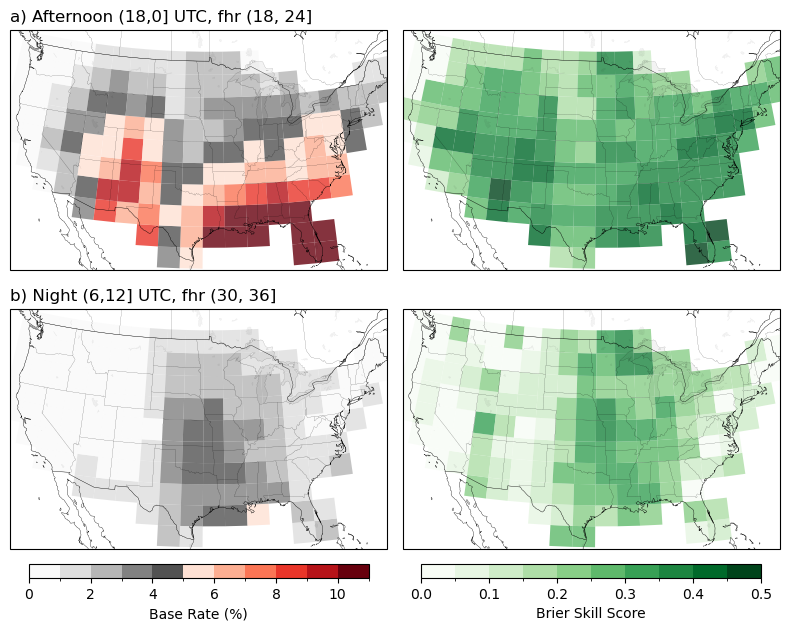

In [15]:
sns.reset_defaults()
%matplotlib inline
extent = (-121, -72, 23, 50)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 6.6), subplot_kw={"projection": map_crs})

legend_kwds = dict(orientation= "horizontal", shrink=0.9, aspect=25, pad=0.05 )

for icat, row in zip([3,5], axes):
    s = fhr_bin.categories[icat]  # pick a forecast hour bin
    gdf = geopandas.GeoDataFrame(
        by_llfhr.xs(f, level="class").xs(s, level="fhr_bin"), crs=ccrs.PlateCarree()
    )
    gdf["Base Rate (%)"] = gdf["base_rate"] * 100
    ax = row[0]
    title = f"a) Afternoon ({s.left%24},{s.right%24}] UTC, fhr {s}" 
    if icat == 5:
        title = f"b) Night ({s.left%24},{s.right%24}] UTC, fhr {s}"  
    ax.set_title(title, loc="left")
    gdf.plot(
        ax=ax,
        column="Base Rate (%)",
        vmin=0,
        vmax=0.02 * twin,
        alpha=0.8,
        cmap=lightning.cmap,
        norm = BoundaryNorm(np.arange(0, 12, 1), ncolors=lightning.cmap.N, clip=True),
        transform=ccrs.PlateCarree(),
        legend=icat==5,
        legend_kwds=legend_kwds | {"label":"Base Rate (%)"},
    )
    ax = row[1]
    gdf.plot(
        ax=ax,
        column="bss",
        vmin=0.0,
        vmax=0.6,
        alpha=0.8,
        cmap="Greens",
        norm = BoundaryNorm(np.arange(0, 0.55, 0.05), ncolors=256),
        transform=ccrs.PlateCarree(),
        legend=icat==5,
        legend_kwds=legend_kwds | {"label":"Brier Skill Score"},
    )
for ax in axes.ravel():
    ax_features(ax)
    ax.set_extent(extent)
fig.tight_layout()
ofile = tmpdir / "spatial.png"
fig.savefig(ofile, dpi=dpi)
logging.warning(ofile)

In [16]:
lat_bin = pd.cut(ensmean.index.get_level_values("lat"), bins=1)
lon_bin = pd.cut(ensmean.index.get_level_values("lon"), bins=1)
by_fhr = ensmean.groupby(
    by=[fhr_bin, lat_bin, lon_bin],
    observed=True,
).progress_apply(statjob)

by_fhr.index.names = ("fhr_bin", "lat_bin", "lon_bin", "class")

100%|██████████| 8/8 [01:41<00:00, 12.63s/it]


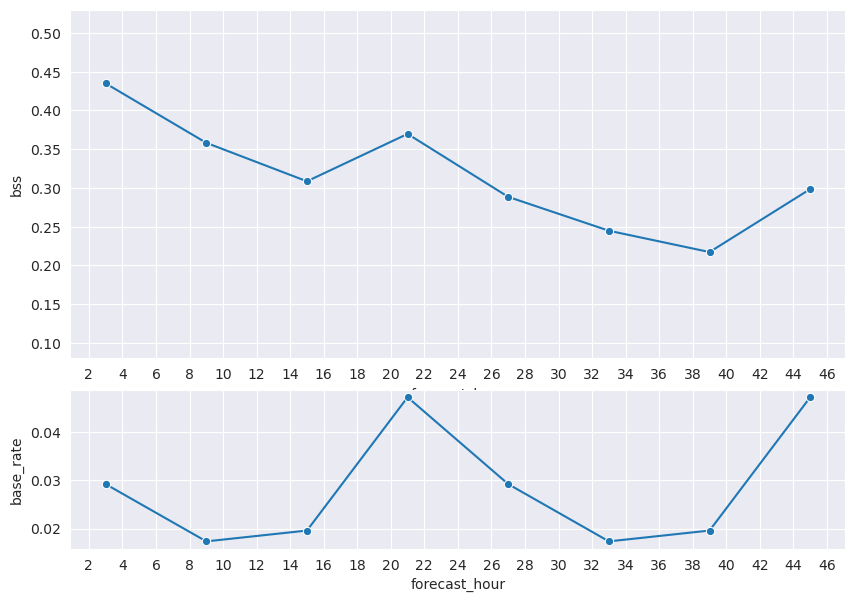

In [17]:
sns.set_style("darkgrid")
# Figure dimensions
# Don't overwrite fig variable from SPC stat_plot earlier.
# You may want to overlay NNPF on SPC stat_plot.
_ = plt.figure(figsize=(10, 7))

topax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
botax = plt.subplot2grid((3, 1), (2, 0), rowspan=1, sharex=topax)
botax.xaxis.set_major_locator(ticker.MultipleLocator(2))

ax = sns.lineplot(
    by_fhr.xs(f, level="class"),
    x="forecast_hour",
    y="bss",
    ax=topax,
    marker="o",
)
ax.set_ylim((0.08, 0.53))
ax = sns.lineplot(
    by_fhr.xs(f, level="class"),
    x="forecast_hour",
    y="base_rate",
    ax=botax,
    marker="o",
    legend=False,
)

0.434
0.358
0.308
0.369
0.288
0.244


2024-06-11 08:29:47,460 /glade/derecho/scratch/ahijevyc/tmp/nnpf.001+cg_20km_4hr.by_fhr.png


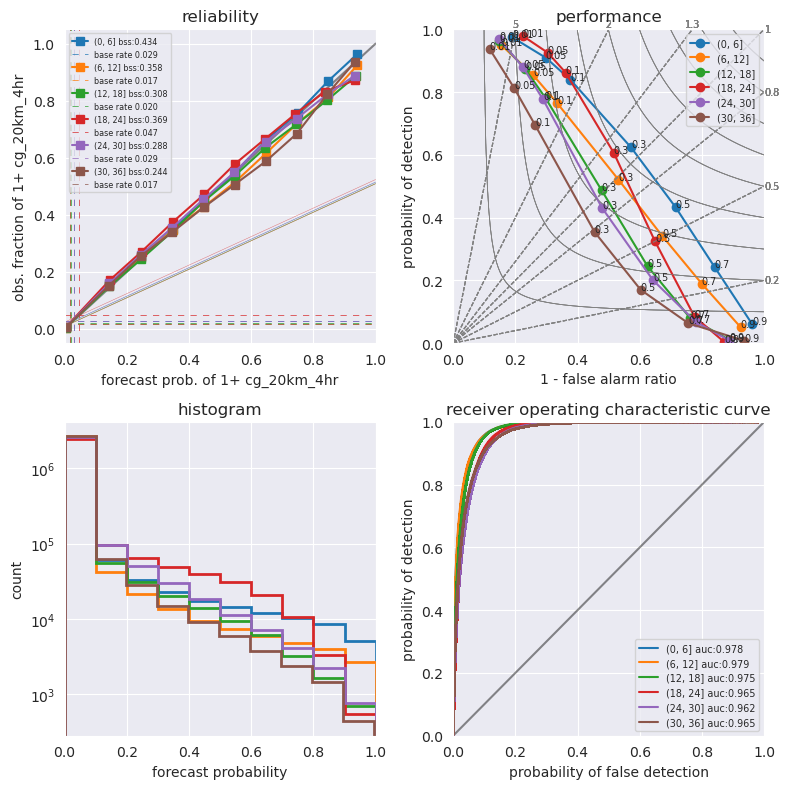

In [18]:
sns.set_style("darkgrid")
ncols, nrows = 2, 2
gfig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 4, nrows * 4))
for name, group in ensmean.groupby(
    by=[fhr_bin, lat_bin, lon_bin],
    observed=True,
):
    obs = group.xs("y_label", axis="columns", level=0)[f]
    fcst = group.xs("y_pred", axis="columns", level=0)[f]
    fcst.name = name[0]
    if name[0].left >= 36:
        continue
    gfig = stat_plots(
        obs,
        fcst,
        thresh=thresh,
        pthresh=pd.Series(
            np.round([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9], 2), name="fcst prob\nthresh"
        ),
        o_thresh_roc=o_thresh,
        sep=0.15,
        fig=gfig,
    )
ofile = tmpdir / f"nnpf.{o_thresh:03d}+{f}.by_fhr.png"
plt.savefig(ofile, dpi=dpi)
logging.warning(ofile)

0.327


2024-06-11 08:30:13,396 /glade/derecho/scratch/ahijevyc/tmp/nnpf.001+cg_20km_4hr.all.initialization_time.valid_time.y.x.forecast_hour.lat.lon.png


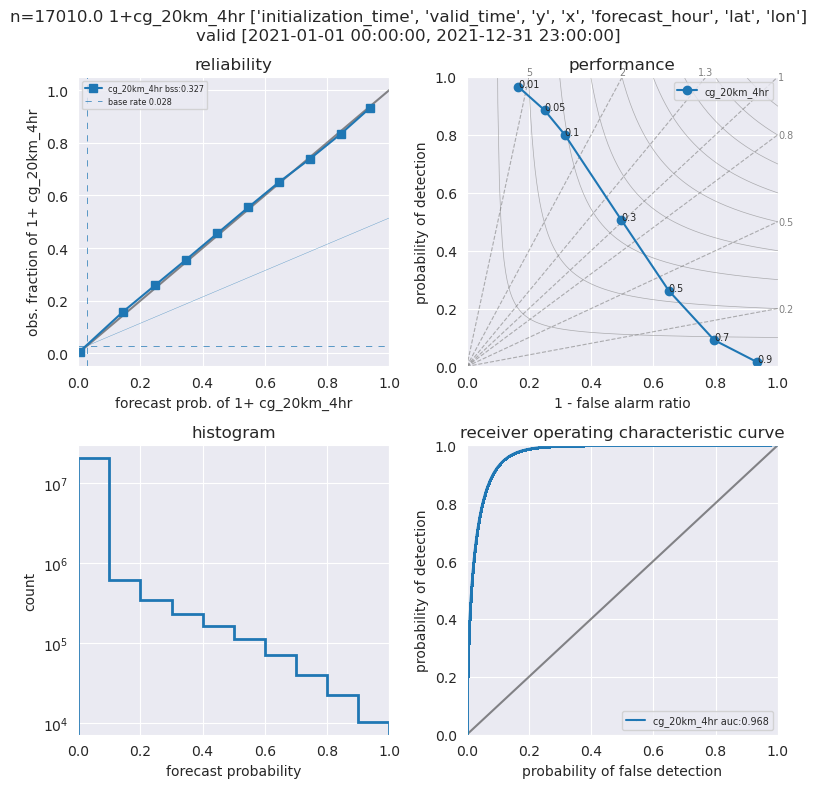

In [19]:
obs = ensmean.xs("y_label", axis="columns", level=0)
fcst = ensmean.xs("y_pred", axis="columns", level=0)

valid_range_str = (
    f'[{ensmean.index.get_level_values("valid_time").min()},'
    f' {ensmean.index.get_level_values("valid_time").max()}]'
)

_ = stat_plots(
    obs[f],
    fcst[f],
    thresh=thresh,
    pthresh=pd.Series(
        np.round([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9], 2), name="fcst prob\nthresh"
    ),
    o_thresh_roc=o_thresh,
    sep=0.15,
    suptitle=f"n={len(ensmean)/G211.mask.values.sum()} {o_thresh}+{f} {levels}\nvalid {valid_range_str}",
)
ofile = tmpdir / f"nnpf.{o_thresh:03d}+{f}.all.{'.'.join(levels)}.png"
plt.savefig(ofile, dpi=dpi)
logging.warning(ofile)

## Restrict NNPF to valid times of SPC Thunderstorm Outlook

In [20]:
def pprod(record: str, fcst=fcst):
    """
    Return NNPF for the same valid range as
    an spc forecast record.
    Valid range may span multiple time windows, each
    with a separate NNPF.
    """
    s = record.name
    issue, valid_start, valid_end = get_issuance_time(s)
    NNPFtimes = pd.date_range(
        start=valid_start + pd.Timedelta(hours=twin / 2),
        end=valid_end - pd.Timedelta(hours=twin / 2),
        freq=f"{twin}h",
    )
    assert fcst.index.names[1] == "valid_time", "valid_time must be MultiIndex level 1"
    try:
        thisfcst = fcst.loc[(slice(None), NNPFtimes), :]
        # Probability of no occurences during multiple time windows
        # equals product of 1-p for each time window.
        prob_none = (1 - thisfcst).groupby(["y", "x"]).prod()
        # Probability of one or more occurrences is 1 minus that.
        p = 1 - prob_none
        return p
    except KeyError as err:
        logging.warning(f"{err} {s} {issue} [{valid_start},{valid_end}]")
    except:
        logging.error(f"pprod broke on {s} {issue} [{valid_start},{valid_end}]")
        sys.exit(1)


fhr_start = int(12 + twin / 2)
fhr_end = int(36 - twin / 2)
logging.warning(
    f"Limit forecast hour range [{fhr_start}, {fhr_end}], get ensemble mean"
)
# selected forecast hours only. drops level by default
fcst = fcst.xs(slice(fhr_start, fhr_end), level="forecast_hour")

pprod_par = tmpdir / f"ps.{args.teststart}-{args.testend}.fhr{fhr_start}-{fhr_end}.{o_thresh:03d}+{platform}.par"
if not clobber and os.path.exists(pprod_par):
    logging.warning(f"use old NNPF probability product output {pprod_par}")
    p = pd.read_parquet(pprod_par)
else:
    time0 = time.time()
    logging.warning(
        f"Save NNPF probability for each spc forecast (i.e. record) to {pprod_par}"
    )
    tqdm.pandas()
    p = spc_fcst.groupby("record").progress_apply(pprod, fcst=fcst)
    p.to_parquet(pprod_par)
    print(time.time() - time0)

logging.warning(
    "get (issuance time, valid hours) from NNPF forecasts matched to SPC records"
)
x = [get_issuance_time(s) for s in tqdm(p.index.get_level_values("record"))]
issue, valid_start, valid_end = map(np.array, zip(*x))

valid_start_hours = np.array([x.hour for x in valid_start])
valid_end_hours = np.array([x.hour for x in valid_end])

2024-06-11 08:30:14,237 Limit forecast hour range [14, 34], get ensemble mean
2024-06-11 08:30:14,805 use old NNPF probability product output /glade/derecho/scratch/ahijevyc/tmp/ps.2021-01-01 00:00:00-2022-01-01 00:00:00.fhr14-34.001+wbug.par
2024-06-11 08:30:16,165 get (issuance time, valid hours) from NNPF forecasts matched to SPC records
100%|██████████| 5579928/5579928 [01:17<00:00, 71613.84it/s]


In [21]:
p

cg_20km_4hr   ic_20km_4hr  \
record                                     y  x                                
enh00_20210101_012000_202101010448-shp.zip 12 48  0.000000e+00  5.960464e-08   
                                              49  0.000000e+00  1.788139e-07   
                                              69  0.000000e+00  0.000000e+00   
                                              70  0.000000e+00  0.000000e+00   
                                           13 47  5.960464e-08  1.192093e-07   
...                                                        ...           ...   
enh20_20211231_311600_202112311237-shp.zip 46 25  0.000000e+00  0.000000e+00   
                                              26  0.000000e+00  0.000000e+00   
                                              27  0.000000e+00  0.000000e+00   
                                              28  0.000000e+00  0.000000e+00   
                                              29  0.000000e+00  0.000000e+00   

                                                  cg.ic_20km_4hr  \
record                                     y  x                    
enh00_20210101_012000_202101010448-shp.zip 12 48    5.960464e-08   
                                              49    1.788139e-07   
                                              69    0.000000e+00   
                                              70    0.000000e+00   
                                           13 47    1.788139e-07   
...                                                          ...   
enh20_20211231_311600_202112311237-shp.zip 46 25    0.000000e+00   
                                              26    0.000000e+00   
                                              27    0.000000e+00   
                                              28    0.000000e+00   
                                              29    0.000000e+00   

                                                  flashes_20km_4hr  \
record                                     y  x                      
enh00_20210101_012000_202101010448-shp.zip 12 48      6.854534e-06   
                                              49      2.563000e-05   
                                              69      5.960464e-08   
                                              70      0.000000e+00   
                                           13 47      3.337860e-06   
...                                                            ...   
enh20_20211231_311600_202112311237-shp.zip 46 25      0.000000e+00   
                                              26      0.000000e+00   
                                              27      0.000000e+00   
                                              28      0.000000e+00   
                                              29      0.000000e+00   

                                                   cg_40km_4hr   ic_40km_4hr  \
record                                     y  x                                
enh00_20210101_012000_202101010448-shp.zip 12 48  4.172325e-07  9.906292e-05   
                                              49  4.231930e-06  1.392066e-03   
                                              69  0.000000e+00  5.960464e-08   
                                              70  0.000000e+00  0.000000e+00   
                                           13 47  3.099442e-06  1.813769e-04   
...                                                        ...           ...   
enh20_20211231_311600_202112311237-shp.zip 46 25  0.000000e+00  0.000000e+00   
                                              26  0.000000e+00  0.000000e+00   
                                              27  0.000000e+00  0.000000e+00   
                                              28  0.000000e+00  0.000000e+00   
                                              29  0.000000e+00  0.000000e+00   

                                                  cg.ic_40km_4hr  \
record                                     y  x                    
enh00_20210101_012000_202101010448-sh

2024-06-11 08:31:55,194 /glade/derecho/scratch/ahijevyc/tmp/leadtime.png


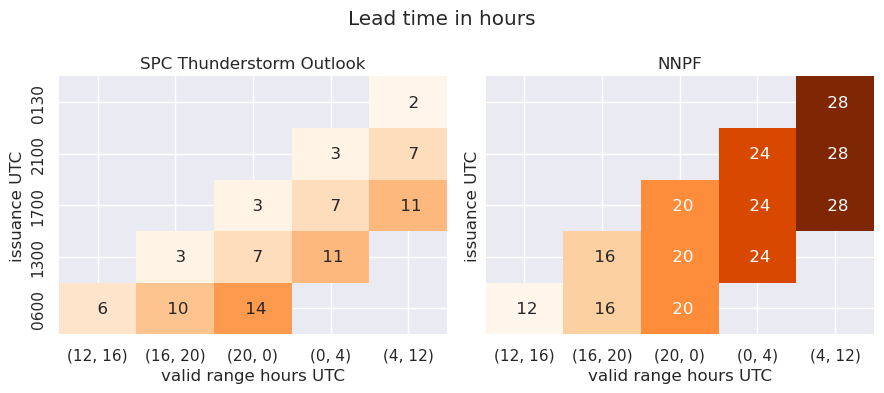

In [22]:
sns.set_theme()
flat_prods = [
    ("0600", 12, 16),
    ("0600", 16, 20), ("1300", 16, 20),
    ("0600", 20, 0), ("1300", 20, 0), ("1700", 20, 0),
    ("1300", 0, 4), ("1700", 0, 4), ("2100", 0, 4),
    ("1700", 4, 12), ("2100", 4, 12), ("0130", 4, 12),
]
leadtime_spc = {(i,v0,v1) : (v0 - (int(i[0:2])+float(i[2:])/60)) % 24 for (i, v0, v1) in flat_prods}
leadtime_spc = pd.Series(leadtime_spc)
leadtime_spc.index = leadtime_spc.index.to_flat_index()

leadtime_NNPF = {(i,v0,v1) : ((v0-12) % 24)+12 for (i, v0, v1) in flat_prods}
leadtime_NNPF = pd.Series(leadtime_NNPF)
leadtime_NNPF.index = leadtime_NNPF.index.to_flat_index()

# Don't use fig. save it from SPC stat_plot
_, ax = plt.subplots(ncols=2, figsize=(9,4), sharey=True)
g = plot_cnt(leadtime_spc, cmap="Oranges", ax=ax[0], vmax=28)
g.set_title("SPC Thunderstorm Outlook")
g = plot_cnt(leadtime_NNPF, cmap="Oranges", ax=ax[1], vmax=28)
g.set_title("NNPF")
plt.suptitle("Lead time in hours")
ofile = tmpdir / "leadtime.png"
plt.tight_layout()
plt.savefig(ofile, dpi=dpi)
logging.warning(ofile)

## Get obs at NNPF times
- verify, plot, overlay on SPC scores

n=353 1+cg_20km_4hr [('0600', 12, 16)] 0.243
n=330 1+cg_20km_4hr [('0600', 16, 20)] 0.264
n=378 1+cg_20km_4hr [('1300', 16, 20)] 0.267
n=335 1+cg_20km_4hr [('0600', 20, 0)] 0.302
n=371 1+cg_20km_4hr [('1300', 20, 0)] 0.302
n=362 1+cg_20km_4hr [('1700', 20, 0)] 0.302
n=351 1+cg_20km_4hr [('1300', 0, 4)] 0.216
n=357 1+cg_20km_4hr [('1700', 0, 4)] 0.216
n=367 1+cg_20km_4hr [('2100', 0, 4)] 0.219
n=344 1+cg_20km_4hr [('1700', 4, 12)] 0.274
n=366 1+cg_20km_4hr [('2100', 4, 12)] 0.277
n=352 1+cg_20km_4hr [('0130', 4, 12)] 0.276


2024-06-11 08:32:59,779 made /glade/derecho/scratch/ahijevyc/tmp/floor_NNPF.001+cg_20km_4hr.png


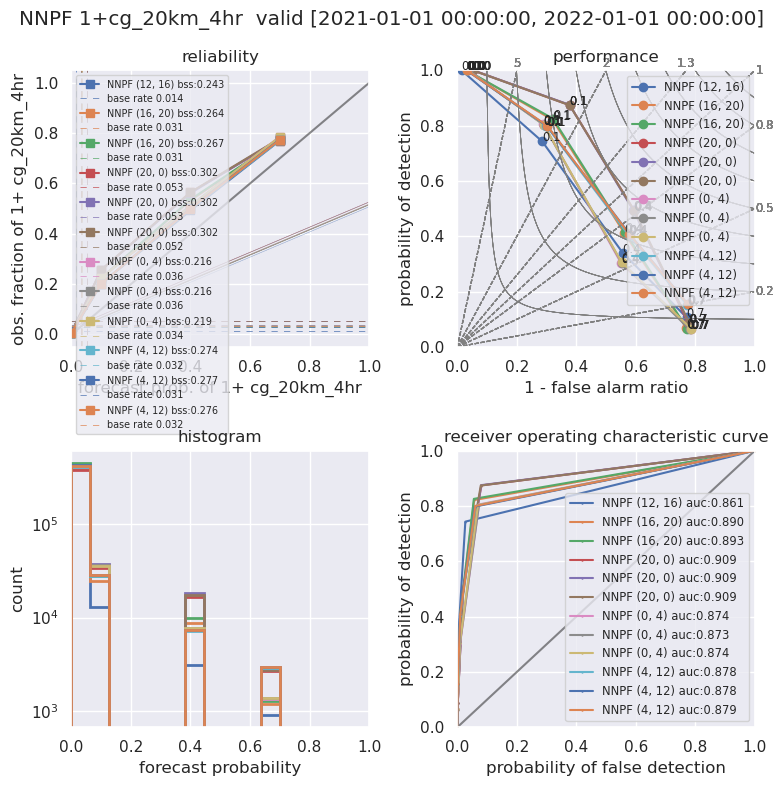

In [23]:
sns.set_theme()
obs = spc_fcst.reorder_levels(p.index.names).loc[p.index, [f, "DN"]]
fcst = p[f]

how="floor"
ztfs_func = partial(lightning.ztfs, how=how)
fcst = fcst.map(ztfs_func)  # round NNPF probs to limited SPC prob levels

keep_SPC_fig = len(prodidss) == 1
if not keep_SPC_fig:
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 4, nrows * 4))

nnpf_bss = {}
for prodids in prodidss:
    iprodid = (
        pd.Series(list(zip(issue, valid_start_hours, valid_end_hours)))
        .isin(prodids)
        .values
    )
    print(f"n={iprodid.sum()/G211.mask.values.sum():.0f} {o_thresh}+{f} {prodids}", end=" ")

    ihr = spc_fcst.prodid.isin(prodids)
    assert ihr.sum()

    # Sanity check
    # NNPF forecasts are missing when obsvar is missing in twin-h time window.
    # However there may be valid obsvar within longer valid time window of SPC forecast.
    # get_obs allows for missing obsvar. It just takes the mean of what is
    # available and then multiplies it by the total time window length.
    # e.g. you get a valid lightning count from
    # get_obs(pd.to_datetime("20210827T20"), pd.to_datetime("20210828T00"), obsvar, 2, rptdist)
    # but labels is missing for one of the 2-h components of that 4-hour SPC forecast valid time window.
    # labels.loc[("2021-08-27", "2021-08-27 21:00:00", 12, 48, slice(None))]
    missing_nnpf_forecasts = set(spc_fcst[ihr].groupby("record").first().index) - set(
        p[iprodid].groupby("record").first().index
    )
    if len(missing_nnpf_forecasts):
        logging.warning(f"{len(missing_nnpf_forecasts)} missing NNPF forecasts")
        print(missing_nnpf_forecasts)

    missing_SPC_forecasts = set(p[iprodid].groupby("record").first().index) - set(
        spc_fcst[ihr].groupby("record").first().index
    )
    if len(missing_SPC_forecasts):
        logging.warning(f"{len(missing_SPC_forecasts)} missing SPC forecasts")
        print(missing_SPC_forecasts)


    thisf = fcst[iprodid]
    thisf.name = "NNPF" + valid_hour_str(prodids)

    fig = stat_plots(
        obs.loc[iprodid, f],
        thisf,
        thresh=thresh,
        pthresh=pthreshSPC,
        o_thresh_roc=o_thresh,
        sep=0.15,
        n_bins=11,
        fig=fig,
    )
    if len(prodids) == 1:
        nnpf_bss[prodids[0]] = brier_skill_score(obs.loc[iprodid,f] >= o_thresh, thisf)        

    # make sure bss is same as before
    t = brier_skill_score(obs.loc[iprodid,f] >= o_thresh, obs.loc[iprodid, "DN"]/100.)
    assert spc_bss[prodids[0]] == t, f"old spc bss {spc_bss[prodids[0]]} != new {t}"

title = f"NNPF {o_thresh}+{f}  valid [{valid_start.min()}, {valid_end.max()}]"
plt.suptitle(title, wrap=True)
plt.tight_layout()

ofile = tmpdir / f"{how}_NNPF.{o_thresh:03d}+{f}.png"
fig.savefig(ofile, dpi=dpi)
logging.warning(f"made {ofile}")

In [24]:
spc_fcst

DN issue     valid_start  \
y  x  record                                                                  
12 48 enh04_20201231_010000_202012311206-shp.zip  0.0  1300  20210101 00:00   
   49 enh04_20201231_010000_202012311206-shp.zip  0.0  1300  20210101 00:00   
   69 enh04_20201231_010000_202012311206-shp.zip  0.0  1300  20210101 00:00   
   70 enh04_20201231_010000_202012311206-shp.zip  0.0  1300  20210101 00:00   
13 47 enh04_20201231_010000_202012311206-shp.zip  0.0  1300  20210101 00:00   
...                                               ...   ...             ...   
46 25 enh20_20211231_311600_202112311237-shp.zip  0.0  1300  20211231 16:00   
   26 enh20_20211231_311600_202112311237-shp.zip  0.0  1300  20211231 16:00   
   27 enh20_20211231_311600_202112311237-shp.zip  0.0  1300  20211231 16:00   
   28 enh20_20211231_311600_202112311237-shp.zip  0.0  1300  20211231 16:00   
   29 enh20_20211231_311600_202112311237-shp.zip  0.0  1300  20211231 16:00   

                                                       valid_end  cg_20km_4hr  \
y  x  record                                                                    
12 48 enh04_20201231_010000_202012311206-shp.zip  20210101 04:00          0.0   
   49 enh04_20201231_010000_202012311206-shp.zip  20210101 04:00          0.0   
   69 enh04_20201231_010000_202012311206-shp.zip  20210101 04:00          0.0   
   70 enh04_20201231_010000_202012311206-shp.zip  20210101 04:00          0.0   
13 47 enh04_20201231_010000_202012311206-shp.zip  20210101 04:00          0.0   
...                                                          ...          ...   
46 25 enh20_20211231_311600_202112311237-shp.zip  20211231 20:00          0.0   
   26 enh20_20211231_311600_202112311237-shp.zip  20211231 20:00          0.0   
   27 enh20_20211231_311600_202112311237-shp.zip  20211231 20:00          0.0   
   28 enh20_20211231_311600_202112311237-shp.zip  20211231 20:00          0.0   
   29 enh20_20211231_311600_202112311237-shp.zip  20211231 20:00          0.0   

                                                  ic_20km_4hr  cg.ic_20km_4hr  \
y  x  record                                                                    
12 48 enh04_20201231_010000_202012311206-shp.zip          0.0             0.0   
   49 enh04_20201231_010000_202012311206-shp.zip          0.0             0.0   
   69 enh04_20201231_010000_202012311206-shp.zip          0.0             0.0   
   70 enh04_20201231_010000_202012311206-shp.zip          0.0             0.0   
13 47 enh04_20201231_010000_202012311206-shp.zip          0.0             0.0   
...                                                       ...             ...   
46 25 enh20_20211231_311600_202112311237-shp.zip          0.0             0.0   
   26 enh20_20211231_311600_202112311237-shp.zip          0.0             0.0   
   27 enh20_20211231_311600_202112311237-shp.zip          0.0             0.0   
   28 enh20_20211231_311600_202112311237-shp.zip          0.0             0.0   
   29 enh20_20211231_311600_202112311237-shp.zip          0.0             0.0   

                                                  flashes_20km_4hr  \
y  x  record                                                         
12 48 enh04_20201231_010000_202012311206-shp.zip               0.0   
   49 enh04_20201231_010000_202012311206-shp.zip               0.0   
   69 enh04_20201231_010000_202012311206-shp.zip               0.0   
   70 enh04_20201231_010000_202012311206-shp.zip               0.0   
13 47 enh04_20201231_010000_202012311206-shp.zip               0.0   
...                                                            ...   
46 25 enh20_20211231_311600_202112311237-shp.zip               0.0   
   26 enh20_20211231_311600_202112311237-shp.zip               0.0   
   27 enh20_20211231_311600_202112311237-shp.zip               0.0   
   28 enh20_20211231_311600_202112311237-shp.zip               0.0   
   29 enh20_20211231_311600_202112311237-shp.zip               0.0   

    

In [25]:
def stats(df, o_thresh=o_thresh):
    labels = df[f] >= o_thresh
    nnpf_pred = df[f+"NNPF"].map(ztfs_func)
    spc_pred = df["DN"]/100.

    bs_nnpf = np.mean((nnpf_pred - labels)**2)
    bs_spc  = np.mean((spc_pred  - labels)**2)
    bss_nnpf = brier_skill_score(labels, nnpf_pred)
    bss_spc  = brier_skill_score(labels,  spc_pred)

    df = pd.Series(
        {
            "bs_nnpf": bs_nnpf,
            "bs_spc": bs_spc,
            "bss_nnpf": bss_nnpf,
            "bss_spc": bss_spc,
            "base_rate": labels.mean(),
            "n": labels.count()/G211.mask.values.sum(),
        }
    )
    return df
import scipy.stats

In [26]:
xx = spc_fcst.join(p, rsuffix="NNPF")
sss = []
for prodid in flat_prods:
    ofile = f"{prodid[0]}.{prodid[1]}.{prodid[2]}.par"
    logging.warning(ofile)
    if os.path.exists(ofile):
        sss.append(pd.read_parquet(ofile).assign(prodid=1000*[prodid]))
        continue
    x = xx[xx["prodid"] == prodid]
    idates = pd.to_datetime(x.valid_start).dt.round(freq="1D")
    ss = []
    for i in tqdm(range(1000)):
        resampledDates = sklearn.utils.resample(idates.unique(), replace=True)
        vc = pd.Series(resampledDates).value_counts()
        xi = pd.concat([x.reindex(x[idates == v].index.repeat(c)) for v, c in vc.items()])
        ss.append(stats(xi))
    ss = pd.concat(ss, axis="columns").T
    ss.to_parquet(ofile)
    print(ofile)
    ss

2024-06-11 08:33:40,950 0600.12.16.par
2024-06-11 08:33:40,971 0600.16.20.par
2024-06-11 08:33:40,993 1300.16.20.par
2024-06-11 08:33:41,024 0600.20.0.par
2024-06-11 08:33:41,048 1300.20.0.par
2024-06-11 08:33:41,071 1700.20.0.par
2024-06-11 08:33:41,096 1300.0.4.par
2024-06-11 08:33:41,113 1700.0.4.par
2024-06-11 08:33:41,130 2100.0.4.par
2024-06-11 08:33:41,185 1700.4.12.par
2024-06-11 08:33:41,206 2100.4.12.par
2024-06-11 08:33:41,222 0130.4.12.par


In [27]:
ss = pd.concat(sss)
ss["d"] = ss["bss_nnpf"] - ss["bss_spc"]
ss

,bs_nnpf,bs_spc,bss_nnpf,bss_spc,base_rate,n,prodid,d
0,0.011772,0.014249,0.242598,0.083250,0.015792,352.0,"(0600, 12, 16)",0.159348
1,0.011462,0.014174,0.225928,0.042797,0.015033,348.0,"(0600, 12, 16)",0.183132
2,0.011676,0.013664,0.227011,0.095437,0.015340,352.0,"(0600, 12, 16)",0.131574
3,0.011172,0.013893,0.224777,0.035997,0.014625,354.0,"(0600, 12, 16)",0.188780
4,0.009335,0.011002,0.253897,0.120646,0.012672,348.0,"(0600, 12, 16)",0.133251
...,...,...,...,...,...,...,...,...
995,0.023566,0.023800,0.272285,0.265066,0.033506,351.0,"(0130, 4, 12)",0.007220
996,0.020860,0.021436,0.284887,0.265133,0.030075,352.0,"(0130, 4, 12)",0.019754
997,0.020355,0.020629,0.278295,0.268568,0.029048,351.0,"(0130, 4, 12)",0.009728
998,0.022327,0.022597,0.262463,0.253546,0.031248,354.0,"(0130, 4, 12)",0.008916


In [28]:
ss["issue"] = ss.prodid.str[0]
ss["start_hr"] = ss.prodid.str[1]
ss["end_hr"] = ss.prodid.str[2]
ss

,bs_nnpf,bs_spc,bss_nnpf,bss_spc,base_rate,n,prodid,d,issue,start_hr,end_hr
0,0.011772,0.014249,0.242598,0.083250,0.015792,352.0,"(0600, 12, 16)",0.159348,0600,12,16
1,0.011462,0.014174,0.225928,0.042797,0.015033,348.0,"(0600, 12, 16)",0.183132,0600,12,16
2,0.011676,0.013664,0.227011,0.095437,0.015340,352.0,"(0600, 12, 16)",0.131574,0600,12,16
3,0.011172,0.013893,0.224777,0.035997,0.014625,354.0,"(0600, 12, 16)",0.188780,0600,12,16
4,0.009335,0.011002,0.253897,0.120646,0.012672,348.0,"(0600, 12, 16)",0.133251,0600,12,16
...,...,...,...,...,...,...,...,...,...,...,...
995,0.023566,0.023800,0.272285,0.265066,0.033506,351.0,"(0130, 4, 12)",0.007220,0130,4,12
996,0.020860,0.021436,0.284887,0.265133,0.030075,352.0,"(0130, 4, 12)",0.019754,0130,4,12
997,0.020355,0.020629,0.278295,0.268568,0.029048,351.0,"(0130, 4, 12)",0.009728,0130,4,12
998,0.022327,0.022597,0.262463,0.253546,0.031248,354.0,"(0130, 4, 12)",0.008916,0130,4,12


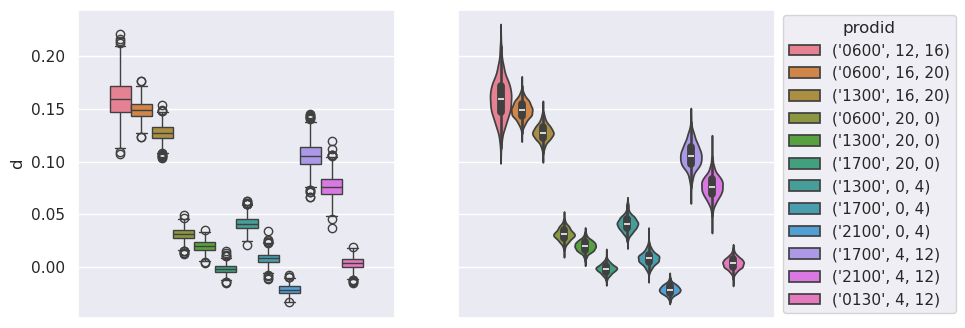

In [147]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9,4))
sns.boxplot(data = ss, y="d", hue="prodid", ax=axes[0], legend=False)
sns.violinplot(data = ss, y="d", hue="prodid", ax=axes[1])
sns.move_legend(axes[1], "center left", bbox_to_anchor=(1,0.5))

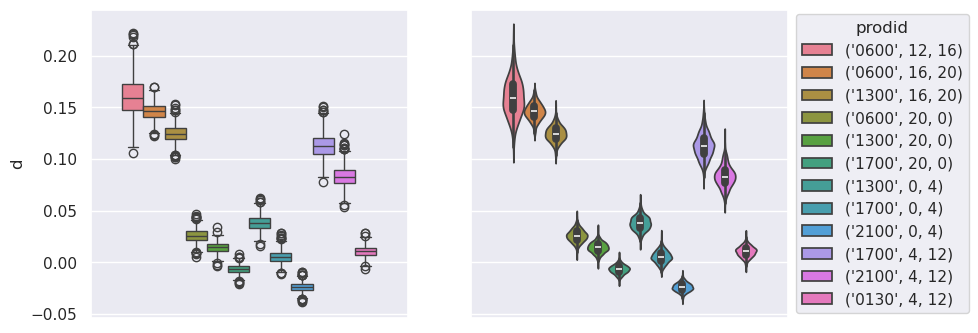

In [29]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(9,4))
sns.boxplot(data = ss, y="d", hue="prodid", ax=axes[0], legend=False)
sns.violinplot(data = ss, y="d", hue="prodid", ax=axes[1])
sns.move_legend(axes[1], "center left", bbox_to_anchor=(1,0.5))

In [30]:
def mean_confidence_interval(data, confidence_level=0.95):
    if False:
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence_level) / 2., n-1)
        return m, h
    else:
        qlo = (1-confidence_level)/2 * 100
        qhi = 100-qlo
        lo, hi = np.percentile(data, [qlo, qhi])
        m = data.mean()
        return lo, data.mean(), hi

In [31]:
def bootstrap(data, **kwargs):
    res =  scipy.stats.bootstrap((data,), np.mean, **kwargs)
    ci_l, ci_u = res.confidence_interval
    return ci_l, np.mean(res.bootstrap_distribution), ci_u

## Compare BSS of SPC and NNPF

prodid
(0130, 4, 12)     Axes(0.125,0.11;0.775x0.77)
(0600, 12, 16)    Axes(0.125,0.11;0.775x0.77)
(0600, 16, 20)    Axes(0.125,0.11;0.775x0.77)
(0600, 20, 0)     Axes(0.125,0.11;0.775x0.77)
(1300, 0, 4)      Axes(0.125,0.11;0.775x0.77)
(1300, 16, 20)    Axes(0.125,0.11;0.775x0.77)
(1300, 20, 0)     Axes(0.125,0.11;0.775x0.77)
(1700, 0, 4)      Axes(0.125,0.11;0.775x0.77)
(1700, 4, 12)     Axes(0.125,0.11;0.775x0.77)
(1700, 20, 0)     Axes(0.125,0.11;0.775x0.77)
(2100, 0, 4)      Axes(0.125,0.11;0.775x0.77)
(2100, 4, 12)     Axes(0.125,0.11;0.775x0.77)
Name: d, dtype: object

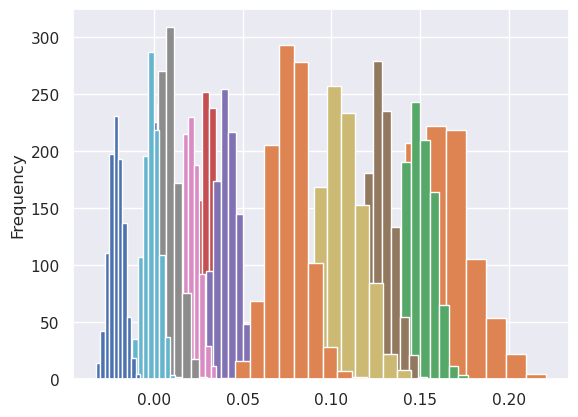

In [150]:
d = "d"
ss.groupby("prodid")[d].plot.hist()

prodid
(0130, 4, 12)     Axes(0.125,0.11;0.775x0.77)
(0600, 12, 16)    Axes(0.125,0.11;0.775x0.77)
(0600, 16, 20)    Axes(0.125,0.11;0.775x0.77)
(0600, 20, 0)     Axes(0.125,0.11;0.775x0.77)
(1300, 0, 4)      Axes(0.125,0.11;0.775x0.77)
(1300, 16, 20)    Axes(0.125,0.11;0.775x0.77)
(1300, 20, 0)     Axes(0.125,0.11;0.775x0.77)
(1700, 0, 4)      Axes(0.125,0.11;0.775x0.77)
(1700, 4, 12)     Axes(0.125,0.11;0.775x0.77)
(1700, 20, 0)     Axes(0.125,0.11;0.775x0.77)
(2100, 0, 4)      Axes(0.125,0.11;0.775x0.77)
(2100, 4, 12)     Axes(0.125,0.11;0.775x0.77)
Name: d, dtype: object

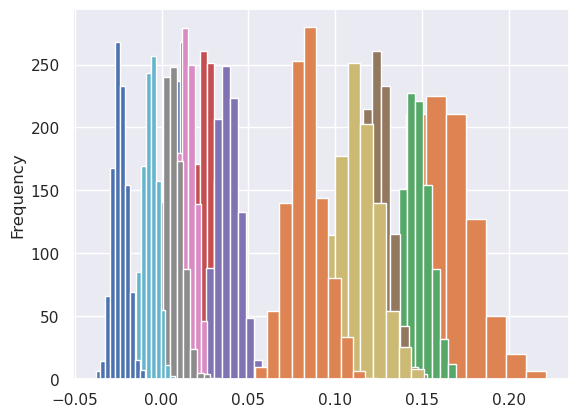

In [32]:
d = "d"
ss.groupby("prodid")[d].plot.hist()

In [151]:
s

l                                          \
start hour                      12        16        20        0         4    
end hour                        16        20        0         4         12   
issuance time (HHMM UTC)                                                     
0130                           NaN       NaN       NaN       NaN -0.005118   
2100                           NaN       NaN       NaN -0.028127  0.059681   
1700                           NaN       NaN -0.008840 -0.001533  0.087174   
1300                           NaN  0.115289  0.011958  0.030990       NaN   
0600                      0.130839  0.135725  0.021822       NaN       NaN   

                                 d                                          \
start hour                      12        16        20        0         4    
end hour                        16        20        0         4         12   
issuance time (HHMM UTC)                                                     
0130                           NaN       NaN       NaN       NaN  0.003499   
2100                           NaN       NaN       NaN -0.021317  0.076322   
1700                           NaN       NaN -0.001586  0.008124  0.106250   
1300                           NaN  0.127698  0.019952  0.041316       NaN   
0600                      0.159905  0.149130  0.031065       NaN       NaN   

                                 h                                          
start hour                      12        16        20        0         4   
end hour                        16        20        0         4         12  
issuance time (HHMM UTC)                                                    
0130                           NaN       NaN       NaN       NaN  0.011902  
2100                           NaN       NaN       NaN -0.014644  0.093767  
1700                           NaN       NaN  0.005425  0.018174  0.126610  
1300                           NaN  0.140493  0.028178  0.052516       NaN  
0600                      0.191205  0.162391  0.040455       NaN       NaN

In [33]:
s

Interval(30, 36, closed='right')

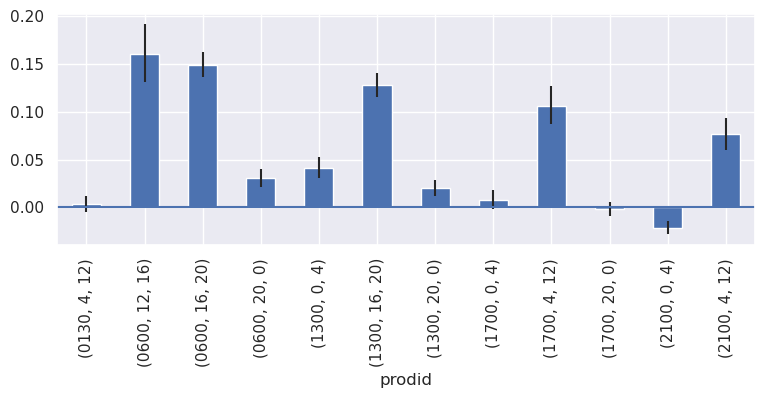

In [152]:
s = ss.groupby("prodid")[d].apply(mean_confidence_interval, confidence_level=.9)
s=pd.DataFrame(s.tolist(), index=s.index, columns=["l", d, "h"])

fig, ax=plt.subplots(figsize=(9,3))
s[d].plot.bar(ax=ax, yerr=(s[d] - s["l"], s["h"] - s[d])).axhline(y=0)


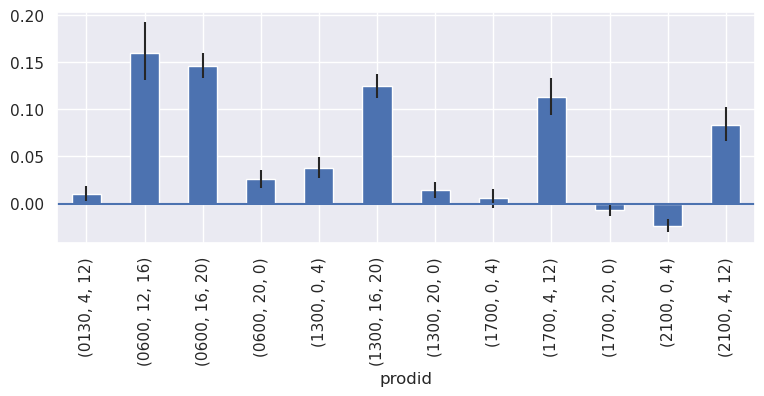

In [34]:
s = ss.groupby("prodid")[d].apply(mean_confidence_interval, confidence_level=.9)
s=pd.DataFrame(s.tolist(), index=s.index, columns=["l", d, "h"])

fig, ax=plt.subplots(figsize=(9,3))
s[d].plot.bar(ax=ax, yerr=(s[d] - s["l"], s["h"] - s[d])).axhline(y=0)


In [153]:
s = ss.groupby("prodid")[d].apply(mean_confidence_interval, confidence_level=0.9)

s = pd.DataFrame(
    s.tolist(),
    index=pd.MultiIndex.from_tuples(s.index, names=["issuance time (HHMM UTC)", "start hour", "end hour"]),
    columns=["l", d, "h"],
)
s = (
    s.reindex(
        [
            ("0600", 12, 16),
            ("0600", 16, 20),
            ("0600", 20, 0),
            ("1300", 0, 4),
            ("1300", 16, 20),
            ("1300", 20, 0),
            ("1700", 0, 4),
            ("1700", 4, 12),
            ("1700", 20, 0),
            ("2100", 0, 4),
            ("2100", 4, 12),
            ("0130", 4, 12),
        ]
    )
    .unstack(level=["start hour", "end hour"])
    .reindex(["0130", "2100", "1700", "1300", "0600"])
)
s

l                                          \
start hour                      12        16        20        0         4    
end hour                        16        20        0         4         12   
issuance time (HHMM UTC)                                                     
0130                           NaN       NaN       NaN       NaN -0.005118   
2100                           NaN       NaN       NaN -0.028127  0.059681   
1700                           NaN       NaN -0.008840 -0.001533  0.087174   
1300                           NaN  0.115289  0.011958  0.030990       NaN   
0600                      0.130839  0.135725  0.021822       NaN       NaN   

                                 d                                          \
start hour                      12        16        20        0         4    
end hour                        16        20        0         4         12   
issuance time (HHMM UTC)                                                     
0130                           NaN       NaN       NaN       NaN  0.003499   
2100                           NaN       NaN       NaN -0.021317  0.076322   
1700                           NaN       NaN -0.001586  0.008124  0.106250   
1300                           NaN  0.127698  0.019952  0.041316       NaN   
0600                      0.159905  0.149130  0.031065       NaN       NaN   

                                 h                                          
start hour                      12        16        20        0         4   
end hour                        16        20        0         4         12  
issuance time (HHMM UTC)                                                    
0130                           NaN       NaN       NaN       NaN  0.011902  
2100                           NaN       NaN       NaN -0.014644  0.093767  
1700                           NaN       NaN  0.005425  0.018174  0.126610  
1300                           NaN  0.140493  0.028178  0.052516       NaN  
0600                      0.191205  0.162391  0.040455       NaN       NaN

In [35]:
s = ss.groupby("prodid")[d].apply(mean_confidence_interval, confidence_level=0.9)

s = pd.DataFrame(
    s.tolist(),
    index=pd.MultiIndex.from_tuples(s.index, names=["issuance time (HHMM UTC)", "start hour", "end hour"]),
    columns=["l", d, "h"],
)
s = (
    s.reindex(
        [
            ("0600", 12, 16),
            ("0600", 16, 20),
            ("0600", 20, 0),
            ("1300", 0, 4),
            ("1300", 16, 20),
            ("1300", 20, 0),
            ("1700", 0, 4),
            ("1700", 4, 12),
            ("1700", 20, 0),
            ("2100", 0, 4),
            ("2100", 4, 12),
            ("0130", 4, 12),
        ]
    )
    .unstack(level=["start hour", "end hour"])
    .reindex(["0130", "2100", "1700", "1300", "0600"])
)
s

l                                          \
start hour                    12        16        20        0         4    
end hour                      16        20        0         4         12   
issuance time (HHMM UTC)                                                   
0130                         NaN       NaN       NaN       NaN  0.002234   
2100                         NaN       NaN       NaN -0.030593  0.066831   
1700                         NaN       NaN -0.013558 -0.004389  0.094356   
1300                         NaN  0.112309  0.005809  0.026830       NaN   
0600                      0.1307  0.132881  0.016614       NaN       NaN   

                                d                                          \
start hour                     12        16        20        0         4    
end hour                       16        20        0         4         12   
issuance time (HHMM UTC)                                                    
0130                          NaN       NaN       NaN       NaN  0.010594   
2100                          NaN       NaN       NaN -0.023928  0.083316   
1700                          NaN       NaN -0.006619  0.005530  0.112952   
1300                          NaN  0.124605  0.014364  0.038085       NaN   
0600                      0.16014  0.146135  0.026014       NaN       NaN   

                                 h                                          
start hour                      12        16        20        0         4   
end hour                        16        20        0         4         12  
issuance time (HHMM UTC)                                                    
0130                           NaN       NaN       NaN       NaN  0.018592  
2100                           NaN       NaN       NaN -0.016736  0.102091  
1700                           NaN       NaN  0.000113  0.015285  0.133480  
1300                           NaN  0.137422  0.022593  0.049816       NaN  
0600                      0.192362  0.159356  0.036064       NaN       NaN

In [154]:
sig = (s["l"] * s["h"] > 0).map(lambda x: "*" if x else "")
sig

start hour,12,16,20,0,4
end hour,16,20,0,4,12
issuance time (HHMM UTC),,,,,
0130,,,,,
2100,,,,*,*
1700,,,,,*
1300,,*,*,*,
0600,*,*,*,,


In [36]:
sig = (s["l"] * s["h"] > 0).map(lambda x: "*" if x else "")
sig

start hour,12,16,20,0,4
end hour,16,20,0,4,12
issuance time (HHMM UTC),,,,,
0130,,,,,*
2100,,,,*,*
1700,,,,,*
1300,,*,*,*,
0600,*,*,*,,


2024-05-15 14:30:31,615 /glade/derecho/scratch/ahijevyc/tmp/1+cg_20km_4hr.heatplot.png


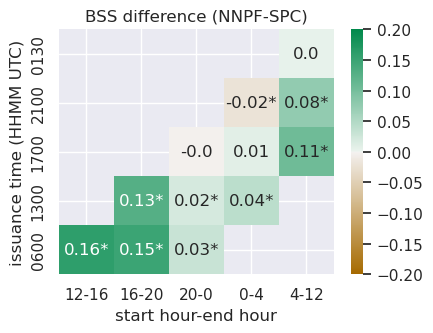

In [157]:
fig, ax = plt.subplots(figsize=(4.5,3.5))

g = sns.heatmap(
    s[d],
    ax=ax,
    annot=s[d].round(decimals=2).astype(str) + sig,
    fmt="",
    vmin=-0.2,
    vmax=0.2,
    cmap=sns.diverging_palette(45, 140, s=100, as_cmap=True),
)
g.set_title(f"BSS difference (NNPF-SPC)")
ofile = tmpdir / f"{o_thresh}+{f}.heatplot.png"
plt.tight_layout()
plt.savefig(ofile, dpi=dpi)
logging.warning(ofile)

2024-06-11 08:38:05,298 /glade/derecho/scratch/ahijevyc/tmp/1+cg_20km_4hr.heatplot.png


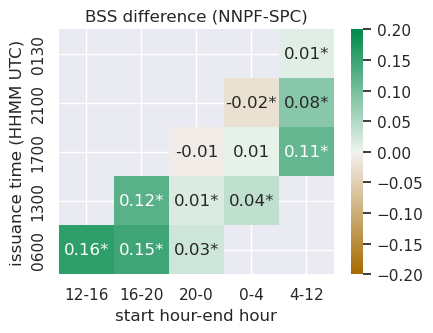

In [37]:
fig, ax = plt.subplots(figsize=(4.5,3.5))

g = sns.heatmap(
    s[d],
    ax=ax,
    annot=s[d].round(decimals=2).astype(str) + sig,
    fmt="",
    vmin=-0.2,
    vmax=0.2,
    cmap=sns.diverging_palette(45, 140, s=100, as_cmap=True),
)
g.set_title(f"BSS difference (NNPF-SPC)")
ofile = tmpdir / f"{o_thresh}+{f}.heatplot.png"
plt.tight_layout()
plt.savefig(ofile, dpi=dpi)
logging.warning(ofile)

2024-05-15 14:23:53,241 /glade/derecho/scratch/ahijevyc/tmp/1+cg_20km_4hr.barplot.png


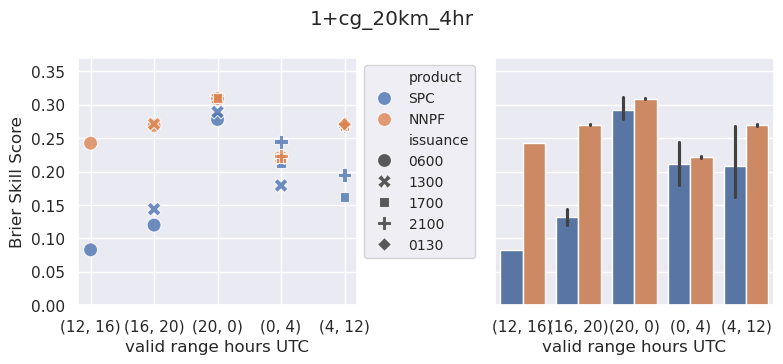

In [140]:
bss_df = pd.concat(
    [pd.Series(spc_bss, name="SPC"), pd.Series(nnpf_bss, name="NNPF")], axis="columns"
)
bss_df.index = pd.MultiIndex.from_tuples(
    [(i, f"({j:d}, {k:d})") for i, j, k in bss_df.index]
)
valid_hr_str = "valid range hours UTC"
bss_df.index.names = ["issuance", valid_hr_str]
bss_df.columns.name = "product"
bss_df = bss_df.reset_index().melt(
    id_vars=["issuance", valid_hr_str], value_name="Brier Skill Score"
)
fig, axes = plt.subplots(ncols=2, figsize=(8, 3.7), sharey=True)

ax = axes[0]
g = sns.scatterplot(
    bss_df,
    x=valid_hr_str,
    y="Brier Skill Score",
    hue="product",
    style="issuance",
    s=100,
    ax=ax,
    alpha=0.8,
)
#sns.move_legend(g, loc="upper left", bbox_to_anchor=(0, 1, 0.1, 0.), ncol=3, fontsize="small")
sns.move_legend(g, loc="upper left", bbox_to_anchor=(1, 1, 0.1, 0.), fontsize="small")


ax = axes[1]
bplot = sns.barplot(data=bss_df, x=valid_hr_str, y="Brier Skill Score", hue="product", legend=False, 
                    ax=ax)


fig.suptitle(f"{o_thresh}+{f}")
ax.set_ylim(0.0, 0.37)


ofile = tmpdir / f"{o_thresh}+{f}.barplot.png"
plt.tight_layout()#rect=[0, 0, 0.85, 1])
fig.savefig(ofile, dpi=dpi)
logging.warning(ofile)

2024-06-11 08:38:35,500 /glade/derecho/scratch/ahijevyc/tmp/1+cg_20km_4hr.barplot.png


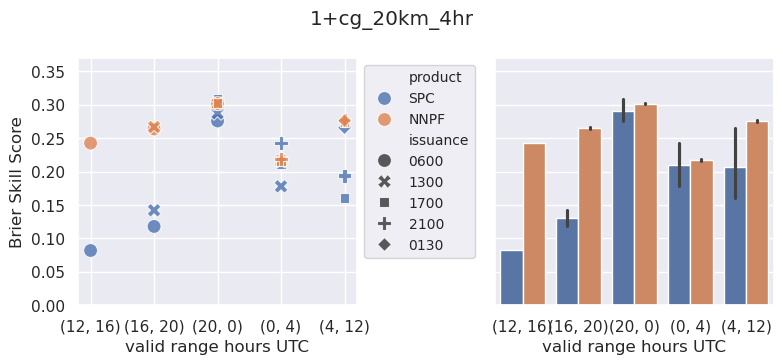

In [38]:
bss_df = pd.concat(
    [pd.Series(spc_bss, name="SPC"), pd.Series(nnpf_bss, name="NNPF")], axis="columns"
)
bss_df.index = pd.MultiIndex.from_tuples(
    [(i, f"({j:d}, {k:d})") for i, j, k in bss_df.index]
)
valid_hr_str = "valid range hours UTC"
bss_df.index.names = ["issuance", valid_hr_str]
bss_df.columns.name = "product"
bss_df = bss_df.reset_index().melt(
    id_vars=["issuance", valid_hr_str], value_name="Brier Skill Score"
)
fig, axes = plt.subplots(ncols=2, figsize=(8, 3.7), sharey=True)

ax = axes[0]
g = sns.scatterplot(
    bss_df,
    x=valid_hr_str,
    y="Brier Skill Score",
    hue="product",
    style="issuance",
    s=100,
    ax=ax,
    alpha=0.8,
)
#sns.move_legend(g, loc="upper left", bbox_to_anchor=(0, 1, 0.1, 0.), ncol=3, fontsize="small")
sns.move_legend(g, loc="upper left", bbox_to_anchor=(1, 1, 0.1, 0.), fontsize="small")


ax = axes[1]
bplot = sns.barplot(data=bss_df, x=valid_hr_str, y="Brier Skill Score", hue="product", legend=False, 
                    ax=ax)


fig.suptitle(f"{o_thresh}+{f}")
ax.set_ylim(0.0, 0.37)


ofile = tmpdir / f"{o_thresh}+{f}.barplot.png"
plt.tight_layout()#rect=[0, 0, 0.85, 1])
fig.savefig(ofile, dpi=dpi)
logging.warning(ofile)